In [1]:
import subprocess
import os
# import torch
# import torch.nn as nn
# import torch.optim as optim
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
import pandas as pd
# from joblib import Parallel, delayed
import numpy as np
# import joblib
import matplotlib.pyplot as plt
# import seaborn as sns
# from pydeseq2.dds import DeseqDataSet
# from pydeseq2.ds import DeseqStats
from sklearn.preprocessing import StandardScaler 
from sklearn.linear_model import ElasticNet
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import ttest_ind, mannwhitneyu, pearsonr, linregress
# from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore")

# Run the hostname command and get the output
hostname = subprocess.check_output("hostname", shell=True, text=True).strip()

# Assert that "login" is not in the hostname
assert "login" not in hostname, f"Error: Hostname contains 'login' -> {hostname}"

print(f"Hostname check passed: {hostname}")
print(os.path.abspath(""))

Hostname check passed: tscc-1-27
/tscc/nfs/home/drahman/temp_testing_3


In [2]:
data_dir = "~/data/"

In [3]:


# -------------------- Data Loading and Preprocessing --------------------

# Load metadata and HRD scores
ann_tcga = pd.read_csv(f"{data_dir}toga.breast.brca.status.txt", sep='\t', index_col=0)
hrd_scores = pd.read_excel(f"{data_dir}tcga.hrdscore.xlsx", index_col=0)

# Load RNAseq data
fpkm = pd.read_csv(f"{data_dir}tcga.brca.rnaseq.unstranded.fpkm.counts.matrix.txt", sep='\t', index_col=0)
deconvo = pd.read_csv(f"{data_dir}Deconvo2.csv",  index_col=0)
tpm = pd.read_csv(f"{data_dir}tpm.csv", index_col=0, low_memory=False)

# Filter metadata
metadata = ann_tcga[~ann_tcga['event.RAD51C'].ne('0')]
metadata = metadata[~metadata['event.PALB2'].ne('0')]
metadata = metadata[metadata['event.BRCA1'] != '1']
metadata.index = metadata.index.str.replace('.', '-', regex=False)
hrd_scores.index = hrd_scores.index.map(lambda x: x[:12])
metadata = metadata.merge(hrd_scores[['HRD-sum']], left_index=True, right_index=True, how='inner')

# Process fpkm data
fpkm = fpkm.set_index('Case ID')
fpkm = fpkm[fpkm['Sample Type'] == 'Primary Tumor']
fpkm = fpkm.drop(columns=["Sample ID","Sample Type"])

# Rename columns using a dictionary constructed from fpkm columns
dick = {}
for i, v in enumerate(fpkm.columns):
    parts = v.split('|')
    if len(parts) > 1:
        dick[parts[0]] = parts[1]
tpm = tpm.rename(columns=dick)
tpm = tpm[~tpm.index.duplicated(keep='first')]

# Keep only Primary Tumor samples in tpm
tpm = tpm.loc[tpm.index.str[13:15] == "01"]

filtered_columns = [col for col in fpkm.columns if '|' in col and 'protein_coding' in col.split('|')[2]]
fpkm = fpkm[filtered_columns]

# Further processing for fpkm
fpkm.columns = [col.split('|')[1] if '|' in col else col for col in fpkm.columns]
fpkm.index = fpkm.index.map(lambda x: x[:12])
fpkm = fpkm.loc[fpkm.index.intersection(metadata.index)]
fpkm.sort_index(inplace=True)
fpkm = fpkm.rename_axis("fpkm", axis="index")
fpkm = fpkm.apply(pd.to_numeric, errors='coerce')
fpkm.fillna(0, inplace=True)

# Process deconvo
deconvo.index = deconvo.index.map(lambda x: x[:12])
deconvo = deconvo.loc[deconvo.index.intersection(metadata.index)]
deconvo.sort_index(inplace=True)
deconvo = deconvo.rename_axis("deconvo", axis="index")
deconvo.fillna(0, inplace=True)

# Process tpm
tpm.index = tpm.index.map(lambda x: x[:12])
tpm = tpm.loc[tpm.index.intersection(metadata.index)]
tpm.sort_index(inplace=True)
tpm = tpm.rename_axis("tpm", axis="index")
tpm = tpm.apply(pd.to_numeric, errors='coerce')
tpm.fillna(0, inplace=True)
tpm = tpm[tpm.columns.intersection(fpkm.columns)]


print(f"fpkm shape: {fpkm.shape}")
print(f"deconvo shape: {deconvo.shape}")
print(f"tpm shape: {tpm.shape}")

# Display counts for PAM50 subtypes
pam50_counts = metadata['event.PAM50'].value_counts()
print(pam50_counts)

# -------------------- Helper Functions --------------------

def downsampling_lumA(metadata, lumA_cutoff):
    """Downsamples LumA samples to match HRD count."""
    lumA_HRD = metadata[(metadata['event.PAM50'] == 'LumA') & (metadata['HRD-sum'] >= lumA_cutoff)]
    lumA_HRP = metadata[(metadata['event.PAM50'] == 'LumA') & (metadata['HRD-sum'] < lumA_cutoff)]
    if lumA_HRP.shape[0] < lumA_HRD.shape[0]:
        return metadata, pd.DataFrame()
    lumA_HRP_downsampled = lumA_HRP.sample(n=lumA_HRD.shape[0], random_state=42)
    df_downsampled = pd.concat([lumA_HRD, lumA_HRP_downsampled])
    df_downsampled = pd.concat([df_downsampled, metadata[metadata['event.PAM50'] != 'LumA']])
    unused_majority = lumA_HRP.loc[~lumA_HRP.index.isin(lumA_HRP_downsampled.index)]
    return df_downsampled, unused_majority

def add_back_test(rna_df, removed_samples, X_test, y_test):
    """Adds back removed samples to the test set if required."""
    add_back_features = rna_df.loc[rna_df.index.intersection(removed_samples.index)]
    add_back_features = add_back_features.sort_index()
    add_back_y = removed_samples.loc[removed_samples.index.intersection(rna_df.index)]
    add_back_y = add_back_y.sort_index()
    X_test = pd.concat([X_test, add_back_features])
    y_test = pd.concat([y_test, add_back_y['HRD-sum'].squeeze()])
    return X_test, y_test

def sigmoid_transform(values, shift=0, scale=1):
    """Apply sigmoid transformation to a series of values."""
    return 1 / (1 + np.exp(-scale * (values - shift)))

def binary_hrd(values, threshold):
    """Convert continuous HRD values into binary classes based on a threshold."""
    return (values >= threshold).astype(int)

def plot_test_train_pam50_dist(metadata, X_train, X_test):
    """Plot HRD-sum distributions for training and test samples, colored by PAM50 subtype."""
    plt.figure(figsize=(10, 6))
    sns.histplot(data=metadata.loc[metadata.index.intersection(X_test.index)],
                 x='HRD-sum', hue='event.PAM50', multiple='layer', kde=True)
    plt.title('Test Distribution')
    plt.xlabel('HRD-sum')
    plt.ylabel('Frequency')
    plt.show()

    plt.figure(figsize=(10, 6))
    sns.histplot(data=metadata.loc[metadata.index.intersection(X_train.index)],
                 x='HRD-sum', hue='event.PAM50', multiple='layer', kde=True)
    plt.title('Train Distribution')
    plt.xlabel('HRD-sum')
    plt.ylabel('Frequency')
    plt.show()


fpkm shape: (887, 19962)
deconvo shape: (835, 9853)
tpm shape: (887, 19969)
event.PAM50
LumA     464
LumB     193
Basal    146
Her2      74
Name: count, dtype: int64


In [4]:
pam50_genes = [
    "ACTR3B", "ANLN", "BAG1", "BCL2", "BIRC5", "BLVRA", "CCNE1", "CDC20", "CDH3", "CENPF",
    "CEP55", "CXXC5", "EGFR", "ERBB2", "ESR1", "EXO1", "FOXA1", "FOXC1", "GRB7", "KIF2C",
    "KRT14", "KRT17", "KRT5", "MAPT", "MDM2", "MELK", "MIA", "MKI67", "MLPH", "MYBL2",
    "NAT1", "ORC6L", "PGR", "PHGDH", "PTTG1", "RRM2", "SFRP1", "SLC39A6", "TMEM45B", "TYMS",
    "UBE2C", "UBE2T", "XBP1", "FGFR4", "SLC7A5", "CDCA1", "GPR160", "MLL5", "ANKRD30A", "ORC6"
]

features_df = tpm
selected_columns = set(deconvo.columns).intersection(tpm.columns).union(pam50_genes)
features_df = features_df[features_df.columns.intersection(selected_columns)]

for i in pam50_genes:
    if i not in features_df.columns:
        print(i)    

ORC6L
CDCA1
MLL5


<Axes: >

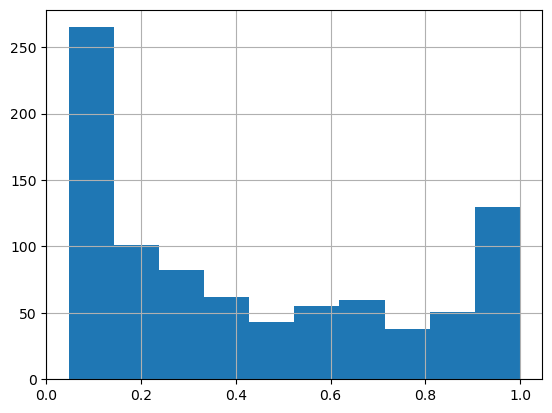

In [5]:
# features_df = tpm
metadata_truncated = metadata.loc[metadata.index.intersection(features_df.index)]
# Add a base HRD status (not used in the final regression but for DESeq2 design)
metadata_truncated['HRD_status_base'] = metadata_truncated['HRD-sum'].apply(lambda x: 'HRD' if x >= 42 else 'HR')
softLabel_metadata = metadata_truncated.sort_index()

features_df = features_df.fillna(0).astype(int)
features_df = features_df[sorted(features_df.columns)]
gene_expression_int = features_df.sort_index()
labels_df = metadata_truncated['HRD-sum'].sort_index()
labels_df = sigmoid_transform(labels_df, 30, 0.1)
labels_df.hist()

In [6]:
import numpy as np
import pandas as pd
from scipy.stats import pearsonr

centroids = pd.read_csv(f"{data_dir}pam50_centroids.csv", index_col=0)
def pam50_classifier(expression_data, centroid_file='pam50_centroids.csv',
                     center=True, zscore=False, return_correlations=True,
                     transpose_expr=False):
    
    # Transpose the expression data if needed
    if transpose_expr:
        expression_data = expression_data.transpose()
    
    # Load PAM50 centroids (genes as index, subtypes as columns)
    centroids = pd.read_csv(centroid_file, index_col=0)
    
    # Find the intersection of genes between the expression data and the centroids
    common_genes = expression_data.index.intersection(centroids.index)
    if len(common_genes) == 0:
        raise ValueError("No PAM50 genes found in the expression data. Please check your gene identifiers.")
    elif len(common_genes) < centroids.shape[0]:
        print(f"Warning: Only {len(common_genes)} out of {centroids.shape[0]} PAM50 genes were found. Proceeding with available genes.")
    
    # Subset both dataframes to the common genes
    expr_subset = expression_data.loc[common_genes].copy()
    cent_subset = centroids.loc[common_genes].copy()
    
    # Apply median-centering for each sample if requested
    if center:
        expr_subset = expr_subset.sub(expr_subset.median(axis=0), axis=1)
    
    # Apply z-score normalization if requested
    if zscore:
        expr_subset = expr_subset.apply(lambda x: (x - x.mean()) / x.std(), axis=0)
        cent_subset = cent_subset.apply(lambda x: (x - x.mean()) / x.std(), axis=0)
    
    samples = expr_subset.columns
    subtypes = cent_subset.columns
    correlations_df = pd.DataFrame(index=samples, columns=subtypes, dtype=float)
    predictions = {}
    
    # Compute Pearson correlation for each sample against each subtype centroid
    for sample in samples:
        sample_vec = expr_subset[sample].values
        for subtype in subtypes:
            centroid_vec = cent_subset[subtype].values
            corr, _ = pearsonr(sample_vec, centroid_vec)
            correlations_df.loc[sample, subtype] = corr
        # Determine the predicted subtype based on highest correlation
        best_subtype = correlations_df.loc[sample].idxmax()
        predictions[sample] = best_subtype
    
    if return_correlations:
        return predictions, correlations_df
    else:
        return predictions


In [7]:
# Run the PAM50 classifier and obtain predictions (and optionally correlations)
predictions, correlations_df = pam50_classifier(
    np.log2(features_df + 1),
    f'{data_dir}/pam50_centroids.csv',
    transpose_expr=True,
    center=True,
    zscore=True
)

# Convert the predictions dictionary to a DataFrame.
# This DataFrame will have the sample identifiers as the index and a single column 'predicted.PAM50'.
pred_df = pd.DataFrame.from_dict(predictions, orient='index', columns=['predicted.PAM50'])

# Merge the predictions with the true PAM50 labels from your metadata.
# Here, metadata_truncated is assumed to contain the true labels in the column 'event.PAM50'
merged_df = pred_df.merge(metadata_truncated[['event.PAM50']], 
                          left_index=True, 
                          right_index=True, 
                          how='left')

# Compute the percentage overlap.
# This calculates the fraction of samples where the predicted subtype equals the true subtype.
overlap_percentage = (merged_df['predicted.PAM50'] == merged_df['event.PAM50']).mean() * 100

print("Percentage Overlap:", overlap_percentage, "%")
mismatches = merged_df[merged_df['predicted.PAM50'] != merged_df['event.PAM50']]

print("Samples where the predicted PAM50 subtype did NOT match the true subtype:")
(mismatches)

Percentage Overlap: 80.15783540022548 %
Samples where the predicted PAM50 subtype did NOT match the true subtype:


,predicted.PAM50,event.PAM50
TCGA-A1-A0SB,Normal,NaN
TCGA-A1-A0SJ,LumB,LumA
TCGA-A1-A0SM,LumB,LumA
TCGA-A1-A0SO,Her2,Basal
TCGA-A2-A04V,LumB,LumA
...,...,...
TCGA-LQ-A4E4,LumB,LumA
TCGA-OL-A5D6,Her2,NaN
TCGA-OL-A66O,LumB,LumA
TCGA-PE-A5DC,LumB,LumA


In [8]:
features_df

,A1BG,A2M,A4GALT,AAAS,AACS,AAGAB,AAK1,AAMDC,AAMP,AAR2,...,ZSWIM8,ZW10,ZWILCH,ZWINT,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1,ZZZ3
tpm,,,,,,,,,,,,,,,,,,,,,
TCGA-A1-A0SB,0,1004,22,35,30,43,9,7,156,90,...,33,43,15,30,27,1,34,342,25,36
TCGA-A1-A0SD,0,713,23,24,10,96,9,23,162,115,...,35,25,12,58,18,1,21,188,16,29
TCGA-A1-A0SE,0,481,17,30,10,81,8,15,197,86,...,23,25,14,71,16,2,23,158,12,27
TCGA-A1-A0SF,0,392,23,39,4,41,4,11,170,87,...,20,28,6,51,14,3,18,234,10,11
TCGA-A1-A0SG,0,364,38,32,21,128,3,8,213,85,...,27,33,10,48,18,0,17,151,21,14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TCGA-OL-A6VR,0,174,81,48,28,100,4,14,286,101,...,30,28,7,36,22,0,14,161,17,23
TCGA-PE-A5DC,0,296,22,45,11,66,3,13,218,104,...,18,17,11,97,16,5,12,180,6,18
TCGA-PE-A5DD,0,374,23,51,7,35,5,14,187,61,...,40,15,7,65,23,9,11,153,11,9


Mean Squared Error: 0.031
R^2 Score: 0.664


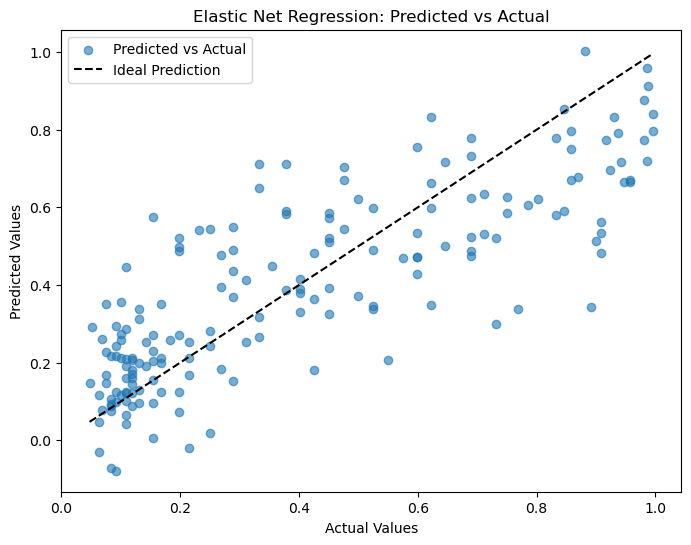

In [9]:
# -------------------- Merge Metadata and Prepare Features --------------------
# Merge metadata; note that 'event.PAM50' is categorical.
# features_df = features_df.merge(metadata_truncated[['event.PAM50']], left_index=True, right_index=True, how='left')

# One-hot encode the PAM50 values
pam50_one_hot = pd.get_dummies(metadata_truncated[['event.PAM50']], prefix='PAM50')

# Merge with features_df
features_df = features_df.merge(pam50_one_hot, left_index=True, right_index=True, how='left')
# features_df.drop(columns=["event.PAM50"])
# -------------------- Model Training Function --------------------
common_de_genes = []  # Will store the gene names used for training
scaler = StandardScaler()

def train_model(params, metadata):
    global common_de_genes
    global features_df
    global scaler
    # Copy and sort features; now features_df contains only numeric (gene expression) data.
    features_df_train = features_df.copy().sort_index()
    
    # Normalize features if requested
    if params['normalization'] == 'StandardScaler':
        features_df_train = pd.DataFrame(scaler.fit_transform(features_df_train),
                                         index=features_df_train.index,
                                         columns=features_df_train.columns)
    elif params['normalization'] == 'log2':
        features_df_train = np.log2(features_df_train + 1)
    
    # Get labels and sort
    labels_df = metadata_truncated['HRD-sum'].sort_index()
    
    # Apply soft labeling
    if params['softlabels'] == "Sigmoid":
        labels_df = sigmoid_transform(labels_df, params['softlabel_thresholds'], params['softlabel_gradients'])
    elif params['softlabels'] == "Binary":
        labels_df = binary_hrd(labels_df, params['softlabel_thresholds'])
    
    # Optionally downsample (if enabled)
    removed_samples = None
    if params['downsample'][0]:
        df_downsampled, removed_samples = downsampling_lumA(metadata_truncated, params['downsample_thresholds'])
        features_df_train = features_df_train.loc[features_df_train.index.intersection(df_downsampled.index)]
        labels_df = df_downsampled.loc[df_downsampled.index.intersection(features_df_train.index), 'HRD-sum']
    
    labels = labels_df.squeeze()
    
    # Split into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(features_df_train, labels, test_size=0.2, random_state=42)
    
    # Optionally add back removed samples to test set
    if params['downsample'][1] and removed_samples is not None:
        X_test, y_test = add_back_test(features_df_train, removed_samples, X_test, y_test)
    
    # Train the ElasticNet model
    warnings.filterwarnings("ignore")
    model = ElasticNet(alpha=params['alpha'], l1_ratio=params['l1_ratio'], max_iter=1000, random_state=42)
    model.fit(X_train, y_train)
    
    # Evaluate on test set
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    # Save the genes used in training for later use in prediction
    common_de_genes = list(features_df_train.columns)
    
    return mse, r2, model, X_train, X_test, y_test, y_pred, y_train

# -------------------- Run with Fixed Parameters --------------------
fixed_params = {
    'softlabels': 'Sigmoid', 
    'softlabel_thresholds': 30, 
    'softlabel_gradients': 0.1, 
    # 'normalization': 'log2', 
    'normalization': 'StandardScaler', 
    'l1_ratio': 0.5, 
    'downsample_thresholds': 35, 
    'downsample': (False, False), 
    'alpha': 0.02
}

mse, r2, model, X_train, X_test, y_test, y_pred, y_train = train_model(fixed_params, metadata)

print(f"Mean Squared Error: {mse:.3f}")
print(f"R^2 Score: {r2:.3f}")

# Save the trained model
# joblib.dump(model, 'best_model.joblib')

# -------------------- Plotting Predicted vs. Actual --------------------
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.6, label='Predicted vs Actual')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'k--', label='Ideal Prediction')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Elastic Net Regression: Predicted vs Actual')
plt.legend(loc="upper left")
plt.show()


In [10]:
# -------------------- Print Number of Non-Zero Genes and ACTR3B Coefficient --------------------
# Get the coefficients from the trained ElasticNet model
non_zero_genes = np.sum(model.coef_ != 0)
actr3b_coef = model.coef_[list(X_train.columns).index("ACTR3B")] if "ACTR3B" in X_train.columns else "Gene not found"
non_zero_gene_list = [gene for gene, coef in zip(X_train.columns, model.coef_) if coef != 0]

print(f"Number of non-zero gene coefficients: {non_zero_genes}")
print(f"Coefficient of ACTR3B: {actr3b_coef}")

Number of non-zero gene coefficients: 204
Coefficient of ACTR3B: 0.0


In [11]:
# -------------------- Validation: Load and Preprocess Expression Data --------------------
ispy2_expr = pd.read_csv(
    f'{data_dir}validation/GSE173839_ISPY2_AgilentGeneExp_durvaPlusCtr_FFPE_meanCol_geneLevel_n105.txt',
    sep='\t'
)
ispy2_expr.set_index('GeneName', inplace=True)
ispy2_expr_transposed = ispy2_expr.T.sort_index()
scaled_validation_data = pd.DataFrame(scaler.fit_transform(ispy2_expr_transposed),
                                      index=ispy2_expr_transposed.index,
                                      columns=ispy2_expr_transposed.columns)
pam50_predictions, correlations_df = pam50_classifier(
    scaled_validation_data,
    f'{data_dir}/pam50_centroids.csv',
    transpose_expr=True,
    center=True,
    zscore=True
)
# Convert the PAM50 predictions dictionary to a DataFrame
pam50_df = pd.DataFrame.from_dict(pam50_predictions, orient='index', columns=['event.PAM50'])
pam50_one_hot = pd.get_dummies(pam50_df, prefix='PAM50')
scaled_validation_data = scaled_validation_data.merge(pam50_one_hot, left_index=True, right_index=True, how='left')
scaled_validation_data.drop(columns=['PAM50_Normal'],inplace=True)

expected_features = model.feature_names_in_

# Add missing columns with NaN or a default value
for col in expected_features:
    if col not in scaled_validation_data.columns:
        scaled_validation_data[col] = 0  # or use 0 if appropriate

# Reorder columns to match the trained model
scaled_validation_data = scaled_validation_data[expected_features]
scaled_validation_data.fillna(0, inplace=True)

# Generate predictions
model_predictions = model.predict(scaled_validation_data)
print(model_predictions)

[ 0.35689025  0.30471085  0.67503725  0.59088051  0.39159753  0.20236342
  0.10709042  0.32549521  0.25354081  0.55680018  0.29185554  0.3429207
  0.54341119  0.06260424  0.42444041  0.46095216  0.77856279  0.54048717
  0.20304857  0.20585163  0.35997589  0.45030188  0.46649163  0.24169198
  0.10015713  0.37869786  0.33518371  0.60137761  0.5985074   0.36950314
  0.74210265  0.40215164  0.41618913  0.38312592  0.48722791  0.71330139
  0.13110613  0.63182325  0.54353217  0.45971148  0.10868756  0.60806602
  0.3828073   0.52890207  0.39793899  0.27934353  0.46944523  0.19985539
  0.85599653  0.80852564  0.41687406  0.30205327  0.49470691  0.69863155
  0.56167082  0.43947081  0.23876632  0.59146918  0.2146702   0.42156408
  0.28247083  0.50433394  0.29884128  0.13523712  0.60253535  0.435276
  0.54491436 -0.06234362  0.76144701  0.53760501  0.46997195  0.43595662
  0.27095884  0.65112246  0.15777037  0.74661246  0.6640408   0.59530563
  0.61758434  0.14573686  0.02902466  0.76265083  0.58

In [12]:
scaled_validation_data

,A1BG,A2M,A4GALT,AAAS,AACS,AAGAB,AAK1,AAMDC,AAMP,AAR2,...,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1,ZZZ3,PAM50_Basal,PAM50_Her2,PAM50_LumA,PAM50_LumB
102596,1.853605,-1.488283,1.176187,-0.440010,0.954111,-1.765527,0.621141,-0.450718,0.140778,0.454385,...,0.986310,1.073284,0.050600,-1.249579,-0.290631,0.548613,False,False,False,True
111922,1.245947,0.466949,0.636319,-1.017986,2.909086,0.210025,0.810914,-0.784326,0.110976,-1.001178,...,-1.101408,-0.709420,-0.180689,0.825747,-2.056263,-0.069494,False,True,False,False
115724,0.421268,0.928057,1.909854,-1.559013,-1.364214,-0.588371,-0.258383,0.078209,0.525910,-0.745227,...,-2.011439,-1.607048,-2.163166,1.532327,-0.230935,0.139572,True,False,False,False
123591,0.735948,-1.507310,0.567105,-1.353159,0.357744,-0.351304,0.172255,-1.732401,1.403918,-0.690934,...,-0.668060,1.442065,0.899762,0.906499,0.315516,2.130237,True,False,False,False
134956,0.562332,-0.155323,0.400992,1.816469,0.969908,1.973035,-1.225495,-0.396542,0.441089,-0.688349,...,-0.430993,0.158393,-0.177385,-0.062525,1.302800,-0.837581,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
944184,3.275090,0.262137,-0.789486,0.766085,0.006244,2.419919,-0.630630,1.294311,1.403918,2.388242,...,1.539466,-1.148818,-0.454931,-0.345157,0.848190,0.253194,False,False,False,True
965961,-1.442940,-0.535849,-0.651059,-0.936172,-0.578274,1.196439,0.391224,0.105296,-0.099929,-1.055471,...,-0.805712,-0.809854,0.969148,0.825747,0.010146,-0.642151,True,False,False,False
979809,-0.262347,1.196664,0.442520,-0.310692,0.022042,-0.032491,1.803573,0.614263,1.486446,1.485948,...,0.675319,1.467173,0.856808,0.361423,0.248931,-0.219475,False,False,False,False
989123,-0.403410,1.868181,1.909854,-0.030941,0.268882,-1.114276,1.285347,-0.516299,1.415380,0.123458,...,2.135956,-0.084846,0.803942,-1.071925,-0.180423,1.348515,True,False,False,False


102596    0.356890
111922    0.304711
115724    0.675037
123591    0.590881
134956    0.391598
            ...   
944184    0.393915
965961    0.594062
979809    0.640605
989123    0.518554
999675    0.278184
Length: 105, dtype: float64


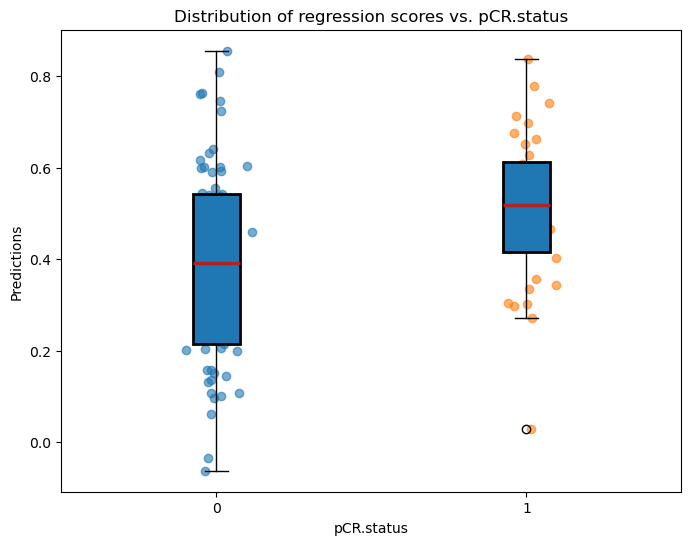

Welch's t-test: t = -3.3046, p = 0.0014
Mann-Whitney U test: U = 799.0000, p = 0.0028


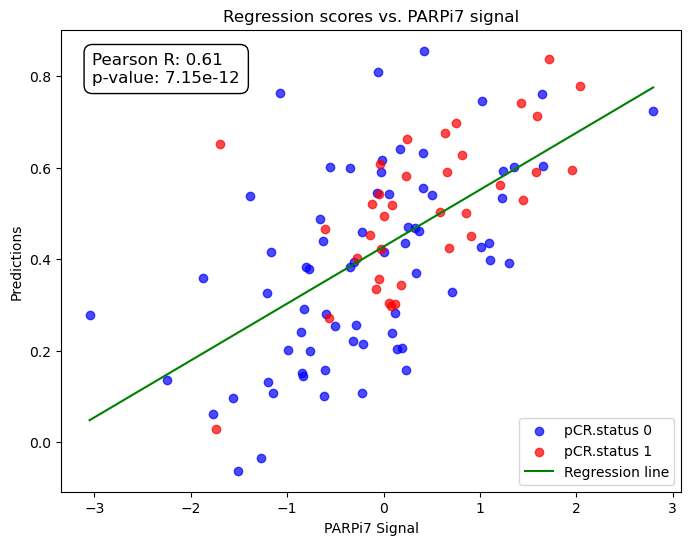

In [13]:


# -------------------- Process Response Data and Merge Predictions --------------------
ispy2_response = pd.read_csv(
    f'{data_dir}validation/GSE173839_ISPY2_DurvalumabOlaparibArm_biomarkers.csv'
)
# Adjust pCR.status (-1 indicates control arm)
ispy2_response.loc[ispy2_response["pCR.status"] == -1, "pCR.status"] = 0
ispy2_response.sort_values(by='ResearchID', inplace=True)
ispy2_response["ResearchID"] = ispy2_response["ResearchID"].astype(str).str.strip()

# Ensure the expression data and response data have matching indices
ispy2_expr = ispy2_expr[ispy2_response["ResearchID"]]
ispy2_response.set_index('ResearchID', inplace=True)
common_indices = ispy2_expr_transposed.index.intersection(ispy2_response.index)
filtered_ispy_probe = ispy2_expr_transposed.loc[common_indices]
filtered_ispy_response = ispy2_response.loc[common_indices]

# Append model predictions to the response DataFrame
filtered_ispy_response['predictions'] = model_predictions

# -------------------- Further Visualization and Statistical Testing --------------------
# For example, plotting box plots and scatter plots and performing tests can proceed as before.
# (Your remaining plotting and testing code remains unchanged.)

# Assuming scaled_validation_data was already defined and has sample IDs as its index
model_predictions = model.predict(scaled_validation_data)
# Create a Series for predictions using the same index as the validation data
model_predictions_series = pd.Series(model_predictions, index=scaled_validation_data.index)
print(model_predictions_series)

# -------------------------
# 2. Load and Preprocess Response Data
# -------------------------
ispy2_response = pd.read_csv(
    f'{data_dir}validation/GSE173839_ISPY2_DurvalumabOlaparibArm_biomarkers.csv'
)
# Adjust pCR.status (-1 indicates control arm)
ispy2_response.loc[ispy2_response["pCR.status"] == -1, "pCR.status"] = 0

# Sort and clean ResearchID, then set it as the index
ispy2_response.sort_values(by='ResearchID', inplace=True)
ispy2_response["ResearchID"] = ispy2_response["ResearchID"].astype(str).str.strip()
ispy2_response.set_index('ResearchID', inplace=True)

# -------------------------
# 3. Merge Expression and Response Data
# -------------------------
# Use the sample IDs (from the predictions Series) to find common indices
common_indices = model_predictions_series.index.intersection(ispy2_response.index)

# Subset the response DataFrame to the common indices
filtered_ispy_response = ispy2_response.loc[common_indices].copy()
# Append the predictions (aligned by sample ID)
filtered_ispy_response['predictions'] = model_predictions_series.loc[common_indices]

# -------------------------
# 4. Visualization: Box Plot of Predictions by pCR.status using Matplotlib
# -------------------------
# Group data by pCR.status
unique_status = sorted(filtered_ispy_response['pCR.status'].unique())
data_to_plot = [
    filtered_ispy_response.loc[filtered_ispy_response['pCR.status'] == status, 'predictions']
    for status in unique_status
]

plt.figure(figsize=(8, 6))
boxprops = dict(linestyle='-', linewidth=2, color='black')
medianprops = dict(linestyle='-', linewidth=2.5, color='firebrick')
plt.boxplot(data_to_plot, labels=unique_status, patch_artist=True, 
            boxprops=boxprops, medianprops=medianprops)

# Overlay individual data points with a slight x-axis jitter
for i, status in enumerate(unique_status):
    y = filtered_ispy_response.loc[filtered_ispy_response['pCR.status'] == status, 'predictions']
    x = np.random.normal(i + 1, 0.04, size=len(y))  # positions start at 1 for boxplot groups
    plt.scatter(x, y, alpha=0.6)

plt.title("Distribution of regression scores vs. pCR.status")
plt.xlabel("pCR.status")
plt.ylabel("Predictions")
plt.show()

# -------------------------
# 5. Statistical Testing: Welch's t-test & Mann-Whitney U Test
# -------------------------
group_0 = filtered_ispy_response.loc[filtered_ispy_response['pCR.status'] == 0, 'predictions']
group_1 = filtered_ispy_response.loc[filtered_ispy_response['pCR.status'] == 1, 'predictions']

t_stat, p_value_t = ttest_ind(group_0, group_1, equal_var=False)
print(f"Welch's t-test: t = {t_stat:.4f}, p = {p_value_t:.4f}")

u_stat, p_value_u = mannwhitneyu(group_0, group_1, alternative='two-sided')
print(f"Mann-Whitney U test: U = {u_stat:.4f}, p = {p_value_u:.4f}")

# -------------------------
# 6. Visualization: Scatter Plot with Pearson Correlation using Matplotlib
# -------------------------
# Make sure the response DataFrame has the PARPi7_sig. column
x = filtered_ispy_response['PARPi7_sig.']
y = filtered_ispy_response['predictions']

# Calculate Pearson correlation coefficient and linear regression line
r_value, p_value = pearsonr(x, y)
slope, intercept, r_value_lin, p_value_lin, std_err = linregress(x, y)
line_x = np.linspace(x.min(), x.max(), 100)
line_y = intercept + slope * line_x

plt.figure(figsize=(8, 6))
# Define colors for each pCR.status (assuming binary: 0 and 1)
colors = {0: 'blue', 1: 'red'}

for status in unique_status:
    subset = filtered_ispy_response[filtered_ispy_response['pCR.status'] == status]
    plt.scatter(subset['PARPi7_sig.'], subset['predictions'], color=colors[status], 
                label=f"pCR.status {status}", alpha=0.7)

plt.plot(line_x, line_y, color='green', label='Regression line')
plt.xlabel("PARPi7 Signal")
plt.ylabel("Predictions")
plt.title("Regression scores vs. PARPi7 signal")
plt.annotate(f"Pearson R: {r_value:.2f}\np-value: {p_value:.2e}", 
             xy=(0.05, 0.95), xycoords='axes fraction', fontsize=12,
             bbox=dict(boxstyle="round,pad=0.5", fc="white", ec="black"),
             verticalalignment='top')
plt.legend()
plt.show()


In [ ]:
genes_validation = pd.read_csv('data/validation/CCLE_RNAseq_genes_counts_20180929.gct', sep="\t", skiprows=2)
# Drop the 'Ensembl IDs' column
genes_validation_transposed = genes_validation.drop(columns=['Name'])

# Set the 'Description' column as the new header (column names)
genes_validation_transposed = genes_validation_transposed.set_index('Description').transpose()
breast_filt = genes_validation_transposed[genes_validation_transposed.index.str.contains('BREAST')]
breast_filt = breast_filt.set_index(breast_filt.index.str.split('_').str[0])
breast_filt.head()

In [ ]:
prism = pd.read_excel('data/validation/PRISM_CCLE.xlsx', skiprows=1)
prism['CellLine'] = prism['CellLine'].replace('-', '', regex=True)

samp_prism = set(list(prism['CellLine']))
samp_val_genes = set(list(breast_filt.index))

common_prism_samples = samp_val_genes.intersection(samp_prism)
breast_filt = breast_filt[breast_filt.index.isin(common_prism_samples)]

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import warnings

# Suppress both PerformanceWarning and SettingWithCopyWarning
warnings.filterwarnings('ignore', category=pd.errors.PerformanceWarning)
warnings.filterwarnings('ignore', category=pd.errors.SettingWithCopyWarning)

# Assuming:
# - top_HRD: List of feature names used in training.
# - ispy2_expr_transposed: Validation dataset (DataFrame).
# - enet_de_model: Trained Elastic Net model.

# Step 1: Identify common features
common_features = list(set(top_genes_de) & set(breast_filt.columns))

# Step 2: Subset the validation dataset
validation_subset = breast_filt.loc[:, breast_filt.columns.isin(common_features)].copy()  # Added .copy()

# Step 3: Handle missing features
missing_features_2 = [feature for feature in common_de_genes.columns if feature not in common_features]

# Add missing features to the validation dataset with default value
for feature in missing_features_2:
    validation_subset.loc[:, feature] = 0  # Use 0, or the training mean/median if available

# Step 4: Reorder columns to match training order
validation_subset = validation_subset[common_de_genes.columns]

# Step 5: Scale and predict
scaler = StandardScaler()
scaled_data = scaler.fit_transform(validation_subset)
predictions_CCLE = enet_de_model.predict(scaled_data)

print(len(missing_features_2))

In [ ]:
prism = prism.sort_values(by = 'CellLine')
prism['predictions'] = predictions_CCLE
for col in prism.iloc[:,3:7].columns:
    fig = px.box(prism, x = 'predictions', y = col, color = 'predictions', points = "all", title = f"Distribution of {col} prism scores against model predictions")
    # Filter the data into two groups based on predictions and pCR.status
    group_0 = prism.loc[
        (prism['predictions'] == 0),
        col
    ]

    group_1 = prism.loc[
        (prism['predictions'] == 1),
        col
    ]

    # Perform Welch's t-test
    t_stat, p_value_t = ttest_ind(group_0, group_1, equal_var=False)
    print(f"Welch's t-test: t = {t_stat:.4f}, p = {p_value_t:.4f}")

    # Perform Mann-Whitney U test
    u_stat, p_value_u = mannwhitneyu(group_0, group_1, alternative='two-sided')
    print(f"Mann-Whitney U test: U = {u_stat:.4f}, p = {p_value_u:.4f}")
    fig.show()